# Calculate SNRs

In [0]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
from scipy.stats import gaussian_kde
import importlib
import scipy.linalg as sl
from collections import OrderedDict
import os

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('muted')
cp2 = sns.color_palette('pastel')

from helper_functions import *

import sys
sys.path.append('../utils')
import reconstructwf as rwf

sys.path.append('../')
import utils

style.use('plotting.mplstyle')

data_dir = '../data/' 

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


### Load in data: posteriors

Load in posterior and prior samples

In [1]:
td_samples, tcutoffs = load_posterior_samples(data_dir)

### Load in data: strain timeseries

Load in time-domain data from the detectors

In [2]:
data_dict =  np.load(data_dir+'LVC_strain_data.npy', allow_pickle=True).item()
wh_data_dict =  np.load(data_dir+'LVC_strain_data_whitened.npy', allow_pickle=True).item()
time_dict_data =  np.load(data_dir+'LVC_time_data.npy', allow_pickle=True).item()

Load in reconstructions from before/after each cutoff time

In [3]:
reconstruction_dict = np.load(data_dir+"waveform_reconstructions_all_detectors.npy",allow_pickle=True).item()

Define cutoff times 

In [4]:
# 0M <-> seconds
t0_0M_dict = {}
t0_0M_geo = 1242442967.405764
dt_10M = 0.0127 # 10 M = 12.7 ms 
dt_1M = dt_10M/10.

ra = 6.07546535866838
dec = -0.8000357325337637
psi = 2.443070879119043

# define t_0M in each detector in seconds
for ifo in ['H1', 'L1', 'V1']: 
    
    t_delay = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix[ifo].location, ra, dec, t0_0M_geo)
    t0_0M_dict[ifo] = t0_0M_geo + t_delay
    
# Max p strain from full run
lnP = reconstruction_dict['full']['L1']['params']['ln_posterior']
i_maxP = np.argmax(lnP)
L1_maxP_strain_wh = np.asarray(reconstruction_dict['full']['L1']['wh'][i_maxP])

# Strains
L1_LVC_strain_h = data_dict['L1']
L1_LVC_strain_wh = wh_data_dict['L1']

# Transform timeseries into into units of M
reconstruction_times_M = (reconstruction_dict['time samples']['L1'] - t0_0M_dict['L1'])/dt_1M
L1_times_M = (time_dict_data['L1'] - t0_0M_dict['L1'])/dt_1M

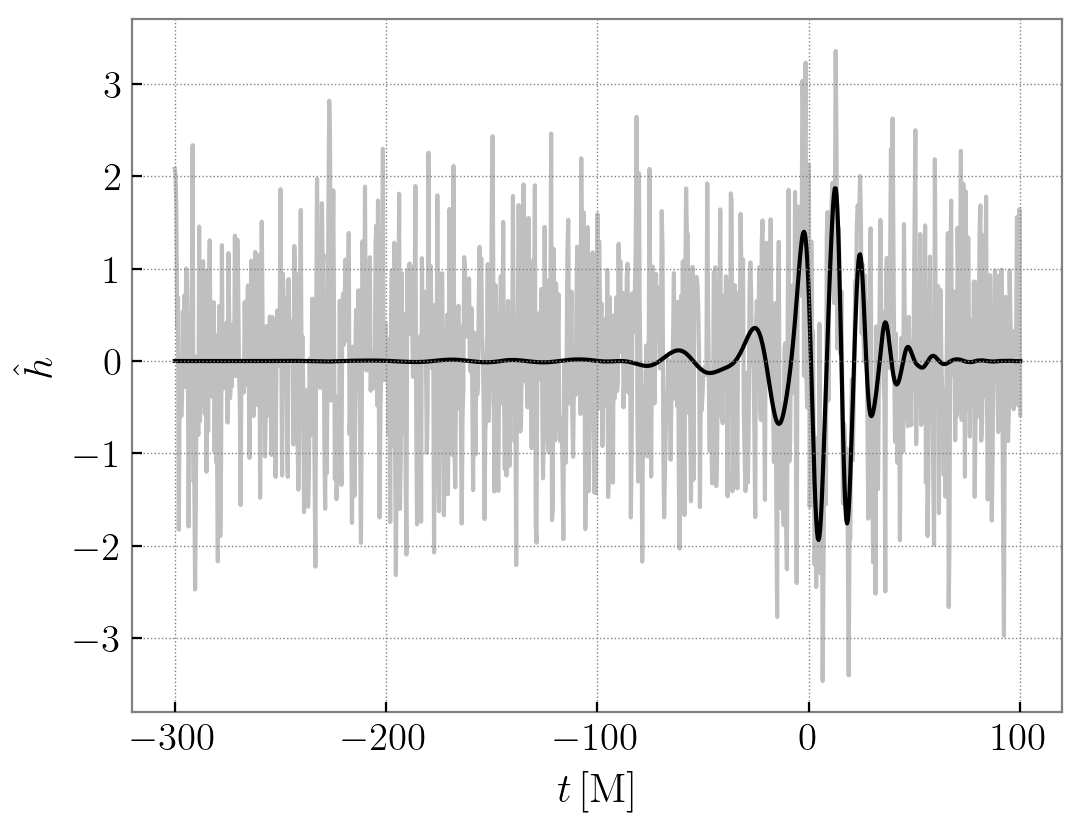

In [6]:
# Plot
gibbs_filter = (L1_times_M > -300) & (L1_times_M < 100)
plt.figure()
plt.plot(L1_times_M[gibbs_filter], L1_LVC_strain_wh[gibbs_filter], color='gray', alpha=0.5)
plt.plot(L1_times_M[gibbs_filter], L1_maxP_strain_wh[gibbs_filter], color='k', lw=1.5)
plt.ylabel(r'$\hat h$', fontsize=15)
plt.xlabel(r'$t\,$[M]', fontsize=15)
plt.show()

### Load data and calculate ACF

In [6]:
# ----------------------------------------------------------------------------
# Load strain data

ifos = ['H1', 'L1', 'V1']
data_path = data_dir+'GW190521_data/{}-{}_GWOSC_16KHZ_R2-1242442952-32.hdf5'
raw_time_dict, raw_data_dict = utils.load_raw_data(ifos=ifos,path=data_path)

psd_path = data_dir+'GW190521_data/glitch_median_PSD_{}.dat'
pe_path = data_dir+'GW190521_data/GW190521_posterior_samples.h5'
pe_out = utils.get_pe(raw_time_dict, path=pe_path, psd_path=psd_path)
tpeak_geocent, tpeak_dict, _, pe_samples, log_prob, pe_psds, maxP_skypos = pe_out

t0_dict, ap_0_dict = utils.get_tgps_and_ap_dicts(t0_0M_geo, ifos, ra, dec, psi)

cond_psds = {}
for ifo, freq_psd in pe_psds.items():
    
    # psd for whitening
    freq, psd = freq_psd.copy().T
    m = freq >= 11
    psd[~m] = 100*max(psd[m]) # set values below 11 Hz to be equal to 100*max(psd)    
    
    cond_psds[ifo] = (freq, psd)
    
    
# ----------------------------------------------------------------------------
# Condition data

ds_factor = 8
f_low = 11

# i0 = index corresponding to peak time
time_dict, data_dict_uncond, i0_dict = utils.condition(raw_time_dict, raw_data_dict,
                                                t0_dict, ds_factor, f_low) 

# Decide how much data to analyze
dt = time_dict['L1'][1] - time_dict['L1'][0]

# Calculate ACF
rho_dict = OrderedDict() 
for ifo, data in data_dict_uncond.items():
    freq, psd = cond_psds[ifo]
    dt = 0.5 / round(freq.max())
    rho = 0.5*np.fft.irfft(psd) / dt # dt comes from numpy fft conventions
    rho_dict[ifo] = rho

Raw H1 data sampled at 16384.0 Hz
Raw L1 data sampled at 16384.0 Hz
Raw V1 data sampled at 16384.0 Hz
H1 1242442967.4275608 [0.7580522873137916, -0.5488112068378234]
L1 1242442967.4248328 [-0.7386332454876581, 0.36522217867663737]
V1 1242442967.4182706 [0.010291861570575614, 0.49946521409762157]
H1 1242442967.4269838 [0.8390995149535796, -0.5422732216415385]
L1 1242442967.4250352 [-0.7654489340960683, 0.48981604792167754]
V1 1242442967.4098494 [0.13992873381093068, 0.20432624720792328]
Rolling H1 by 4 samples
tgps_H1 = 1242442967.426984
t0_H1 - tgps_H1 is 1.81e-05 s

Rolling L1 by 4 samples
tgps_L1 = 1242442967.425035
t0_L1 - tgps_L1 is 1.36e-05 s

Rolling V1 by 3 samples
tgps_V1 = 1242442967.409849
t0_V1 - tgps_V1 is 1.67e-06 s



### Calculate matched filter SNR

For the different runs, calculate the SNR before vs after the cuts, or load if the file already exists.

Functions to do so are in `helper_functions.py`

In [29]:
# Which runs to look at 
runs = [f'{y} {x}' for x in tcutoffs for y in ['insp', 'rd']]
runs.append('full')
runs.append('prior')

# Where to save
savepath = data_dir+'snrs.npy'

# Load dict with snrs if already calculated
redo = True
if os.path.exists(savepath) and not redo: 
    snr_dict = np.load(savepath, allow_pickle=True).item()
    
# Otherwise, calculate snrs    
else:
    # Cycle through detectors and runs
    snr_dict = {}
    for ifo in ['H1', 'L1', 'V1']:

        print(ifo)

        snr_dict_ifo = {}

        for run in runs: 

            times = (time_dict_data[ifo] - t0_0M_dict[ifo])/dt_1M

            # Start and end time of analysis depend on the run
            if run=='full' or run=='prior': 
                tstart = times[0]
                tend = times[-1]
            else:
                
                # Format run into a number
                cut_num = float(((run.split('insp ')[-1]).split('rd ')[-1]).split('m')[-1][:-1])
                cut = -1*cut_num if 'm' in run else cut_num
                
                # pre-t_cut analyses
                if run[0] == 'i':
                    tstart = times[0]
                    tend = cut
                #post-t_cut analyses
                else: 
                    tstart = cut
                    tend =  times[-1]

            # Get times mask for truncation                
            mask = (times > tstart) & (times < tend)

            # Get reconstructions
            try:
                h = np.asarray(reconstruction_dict[run][ifo]['h'])[:,mask]
            except: 
                h = np.asarray(reconstruction_dict['prior'][ifo]['h'])[:,mask]

            # Get ACF
            rho = rho_dict[ifo]
            Nanalyze = len(h.T)
            print(run, Nanalyze)

            # Calculate SNR for each reconstruction
            d = data_dict[ifo][mask]
            snrs = np.zeros(len(h))
            for i, s in enumerate(h):
                snrs[i] = calc_mf_SNR(d, s, rho[:Nanalyze]) 

            snr_dict_ifo[run] = snrs

        snr_dict[ifo] = snr_dict_ifo

        print('')

    # Save snrs dict so we can use it in Fig. 1
    np.save(savepath, snr_dict, allow_pickle=True)

H1
insp m50M 889


/var/folders/w7/r9xkmg4d7n18hlq715yknq9w0000gq/T/ipykernel_5795/1144917638.py:6: RuntimeWarning: invalid value encountered in double_scalars
  snr = inner_product(s, d, rho) / np.sqrt(inner_product(s, s, rho))


rd m50M 544
insp m40M 915
rd m40M 518
insp m37.5M 922
rd m37.5M 511
insp m35M 928
rd m35M 505
insp m32.5M 935
rd m32.5M 498
insp m30M 941
rd m30M 492
insp m27.5M 948
rd m27.5M 485
insp m25M 954
rd m25M 479
insp m22.5M 961
rd m22.5M 472
insp m20M 967
rd m20M 466
insp m17.5M 974
rd m17.5M 459
insp m15M 980
rd m15M 453
insp m12.5M 987
rd m12.5M 446
insp m10M 993
rd m10M 440
insp m7.5M 1000
rd m7.5M 433
insp m5M 1006
rd m5M 427
insp m2.5M 1013
rd m2.5M 420
insp 0M 1019
rd 0M 414
insp 2.5M 1026
rd 2.5M 407
insp 5M 1032
rd 5M 401
insp 7.5M 1039
rd 7.5M 394
insp 10M 1045
rd 10M 388
insp 12.5M 1052
rd 12.5M 381
insp 15M 1058
rd 15M 375
insp 17.5M 1065
rd 17.5M 368
insp 20M 1071
rd 20M 362
insp 30M 1097
rd 30M 336
insp 40M 1124
rd 40M 309
insp 50M 1150
rd 50M 283
full 1433
prior 1433

L1
insp m50M 889
rd m50M 544
insp m40M 915
rd m40M 518
insp m37.5M 922
rd m37.5M 511
insp m35M 928
rd m35M 505
insp m32.5M 935
rd m32.5M 498
insp m30M 941
rd m30M 492
insp m27.5M 948
rd m27.5M 485
insp m25M 954
rd

### Plot results

In [30]:
# Cutoff times we want to plot here
t_cut_to_plot = ['m40M', 'm20M', 'm10M', '0M', '10M', '20M', '30M']
runs_to_plot = [f'{y} {x}' for x in t_cut_to_plot for y in ['insp', 'rd']]
runs_to_plot.append('full')
runs_to_plot.append('prior')

Look at just L1

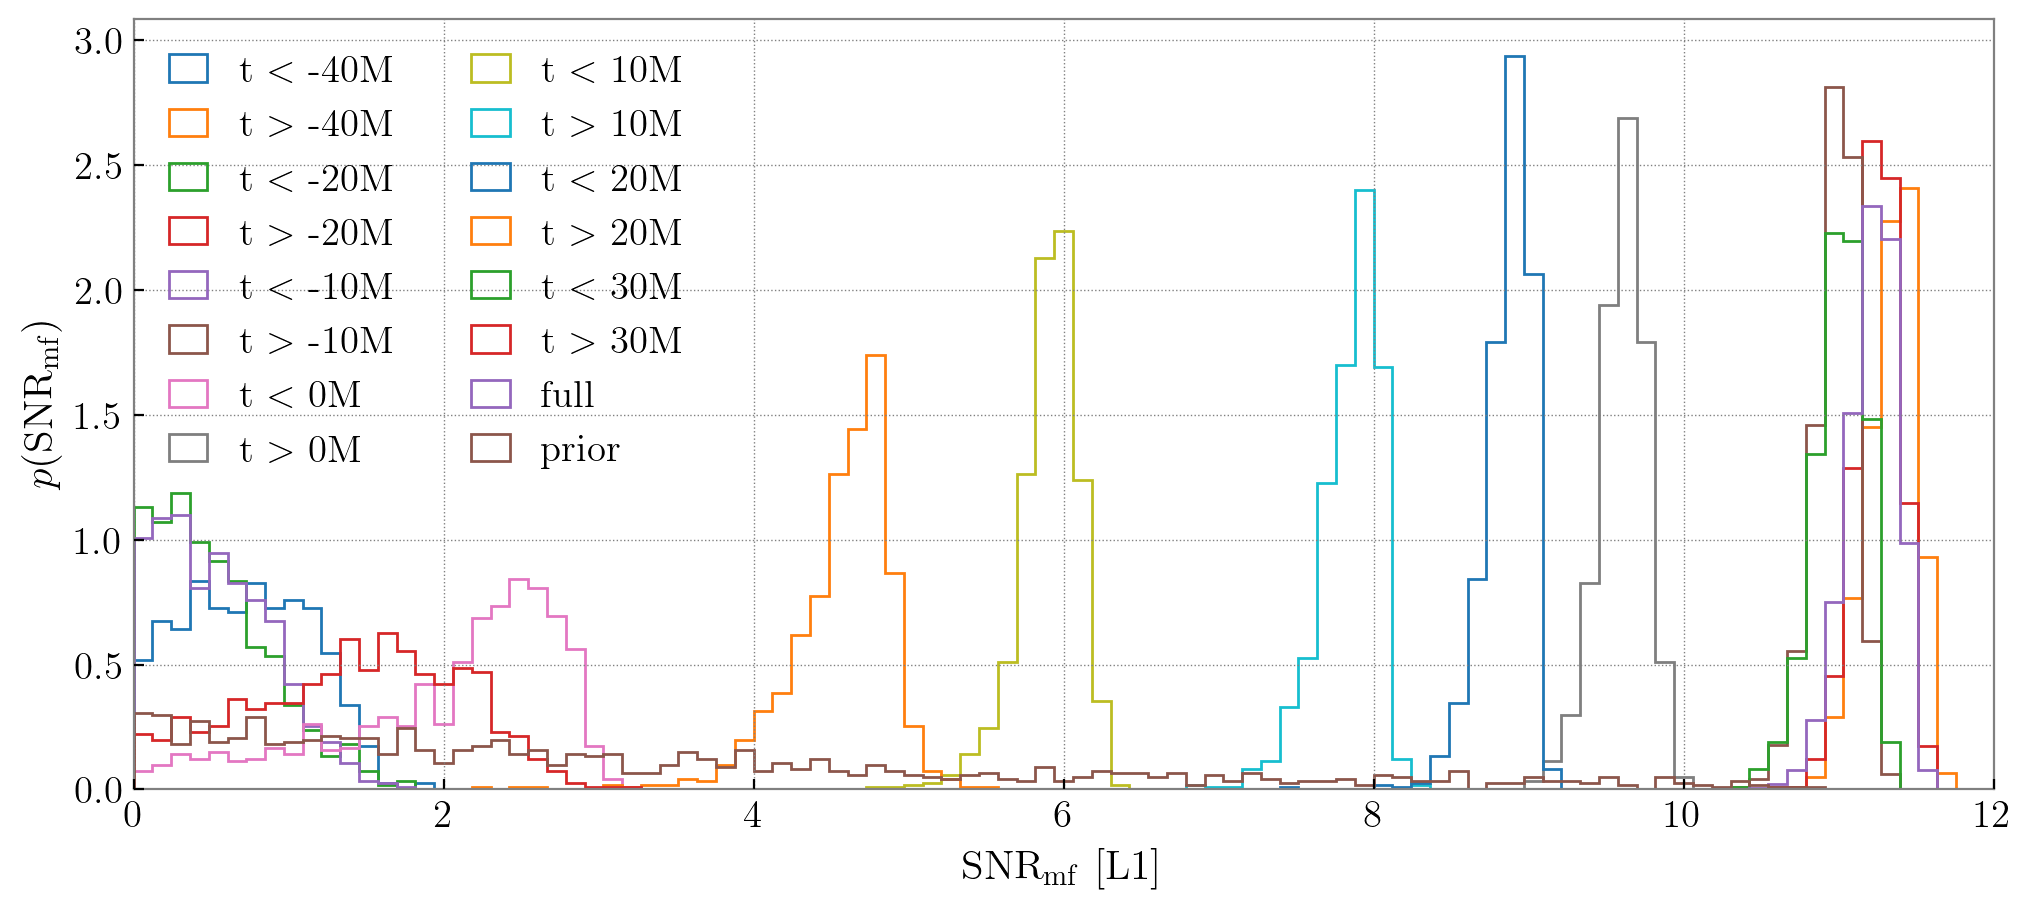

In [31]:
plt.figure(figsize=(12, 5))

for run, snrs in snr_dict['L1'].items(): 
        
    if run in runs_to_plot:
    
        lbl = run.replace('m', '-').replace('insp', 't $<$').replace('rd', 't $>$')
        plt.hist(np.abs(snrs), histtype='step', label=lbl, density=True, bins=np.linspace(0,12,100))
    
plt.legend(loc='upper left',ncols=2)
plt.xlabel(r'$\mathrm{SNR}_\mathrm{mf}$ [L1]', fontsize=15)
plt.ylabel(r'$p(\mathrm{SNR}_\mathrm{mf})$', fontsize=15)
plt.xlim(0,12)
plt.show()

Look at network SNR

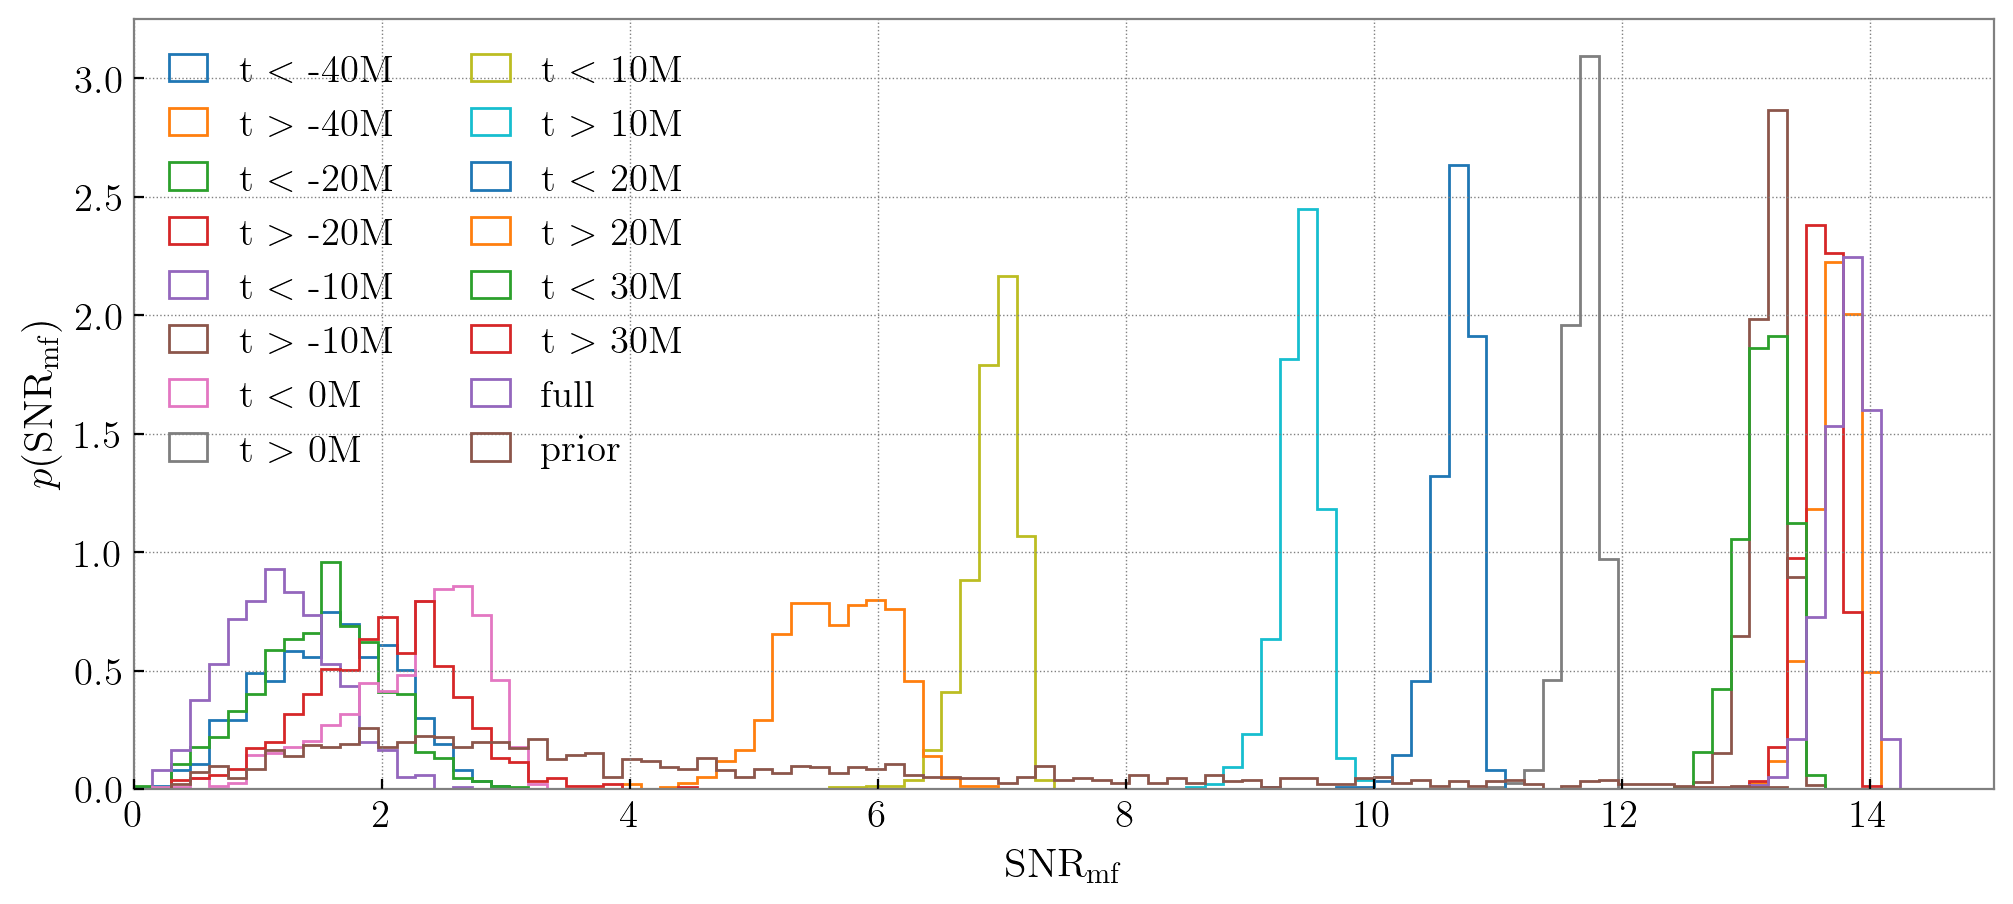

In [32]:
plt.figure(figsize=(12, 5))

for run in snr_dict['L1'].keys(): 
    
    if run in runs_to_plot:
    
        snrs = [calc_network_mf_SNR([L, H, V]) for L, H, V in zip(snr_dict['L1'][run], 
                                                                  snr_dict['H1'][run], 
                                                                  snr_dict['V1'][run])]

        lbl = run.replace('m', '-').replace('insp', 't $<$').replace('rd', 't $>$')
        plt.hist(snrs, histtype='step', label=lbl, density=True, bins=np.linspace(0,15,100))

plt.legend(loc='upper left',ncols=2)
plt.xlabel(r'$\mathrm{SNR}_\mathrm{mf}$', fontsize=15)
plt.ylabel(r'$p(\mathrm{SNR}_\mathrm{mf})$', fontsize=15)
plt.xlim(0,15)
plt.show()

Print out info 

In [33]:
print(('Run\t L1 SNR').expandtabs(12) + '\tNetwork SNR'.expandtabs(5))
print('-----------------------------------')

for run, snrs in snr_dict['L1'].items(): 
    
    if run in runs_to_plot:
    
        # L1
        med_snr_L1 = np.quantile(np.abs(snrs), 0.5)

        # Network 
        network_snrs = np.asarray([calc_network_mf_SNR([L, H, V]) for L, H, V in zip(snr_dict['L1'][run], 
                                                                                     snr_dict['H1'][run], 
                                                                                     snr_dict['V1'][run])])
        med_network_snr = np.quantile(network_snrs[~np.isnan(network_snrs)], 0.5)

        # print
        run_lbl = run.replace('m', '-').replace('insp', 't <').replace('rd', 't >')

        print(f"{run_lbl:<12} {round(med_snr_L1, 2):<10} {round(med_network_snr, 2)}")

Run          L1 SNR     Network SNR
-----------------------------------
t < -40M     0.74       1.6
t > -40M     11.36      13.74
t < -20M     0.46       1.54
t > -20M     11.26      13.62
t < -10M     0.5        1.17
t > -10M     11.0       13.21
t < 0M       2.27       2.4
t > 0M       9.62       11.71
t < 10M      5.92       6.97
t > 10M      7.88       9.43
t < 20M      8.89       10.7
t > 20M      4.64       5.68
t < 30M      11.02      13.17
t > 30M      1.47       2.05
full         11.23      13.84
prior        2.45       3.44
